## This is not working in the mac m1 due to some mpi issues. I would need to try this in some other system.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "1"

In [4]:
import ipyparallel as ipp

In [5]:
cluster = ipp.Cluster(engines='mpi', n=4)

In [6]:
rc = cluster.start_and_connect_sync()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


FileNotFoundError: [Errno 2] No such file or directory: 'mpiexec'

In [6]:
dv = rc[:]

In [31]:
%%px --local
import os
from aps_ai.beamline34IDC.util.shadow.common import plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution
import beamline34IDC.optimization.common as opt_common
import beamline34IDC.optimization.movers as movers
from aps_ai.beamline34IDC.util import clean_up
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import glob
    

In [10]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [11]:
%%px
%load_ext autoreload
%autoreload 2

In [14]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
dv['DEFAULT_RANDOM_SEED'] = DEFAULT_RANDOM_SEED

In [20]:
base_dir = '/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/'
orig_work_dir = f'{base_dir}/work_directory'

temp_work_dir_root = f'{base_dir}/tmp_work_dir_{DEFAULT_RANDOM_SEED}'
if not os.path.isdir(temp_work_dir_root):
    os.mkdir(temp_work_dir_root)
dv['orig_work_dir'] = orig_work_dir
dv['temp_work_dir_root'] = temp_work_dir_root

In [17]:
%%px 
os.chdir(temp_work_dir_root)
temp_work_dir = f'{temp_work_dir_root}/rank_{rank}'
os.mkdir(temp_work_dir)
os.chdir(temp_work_dir)

In [21]:
%%px
dat_files = glob.glob(f'{orig_work_dir}/*.dat')
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [24]:
%%px --local
move_motors = ['hkb_4']
input_beam_path = "primary_optics_system_beam.dat"

motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'

In [25]:
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [33]:
%%px
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

%px:   0%|          | 0/1 [00:02<?, ?tasks/s]

[stdout:0] 0.00011041596492043902


%px:   0%|          | 0/1 [00:02<?, ?tasks/s]

[output:0]

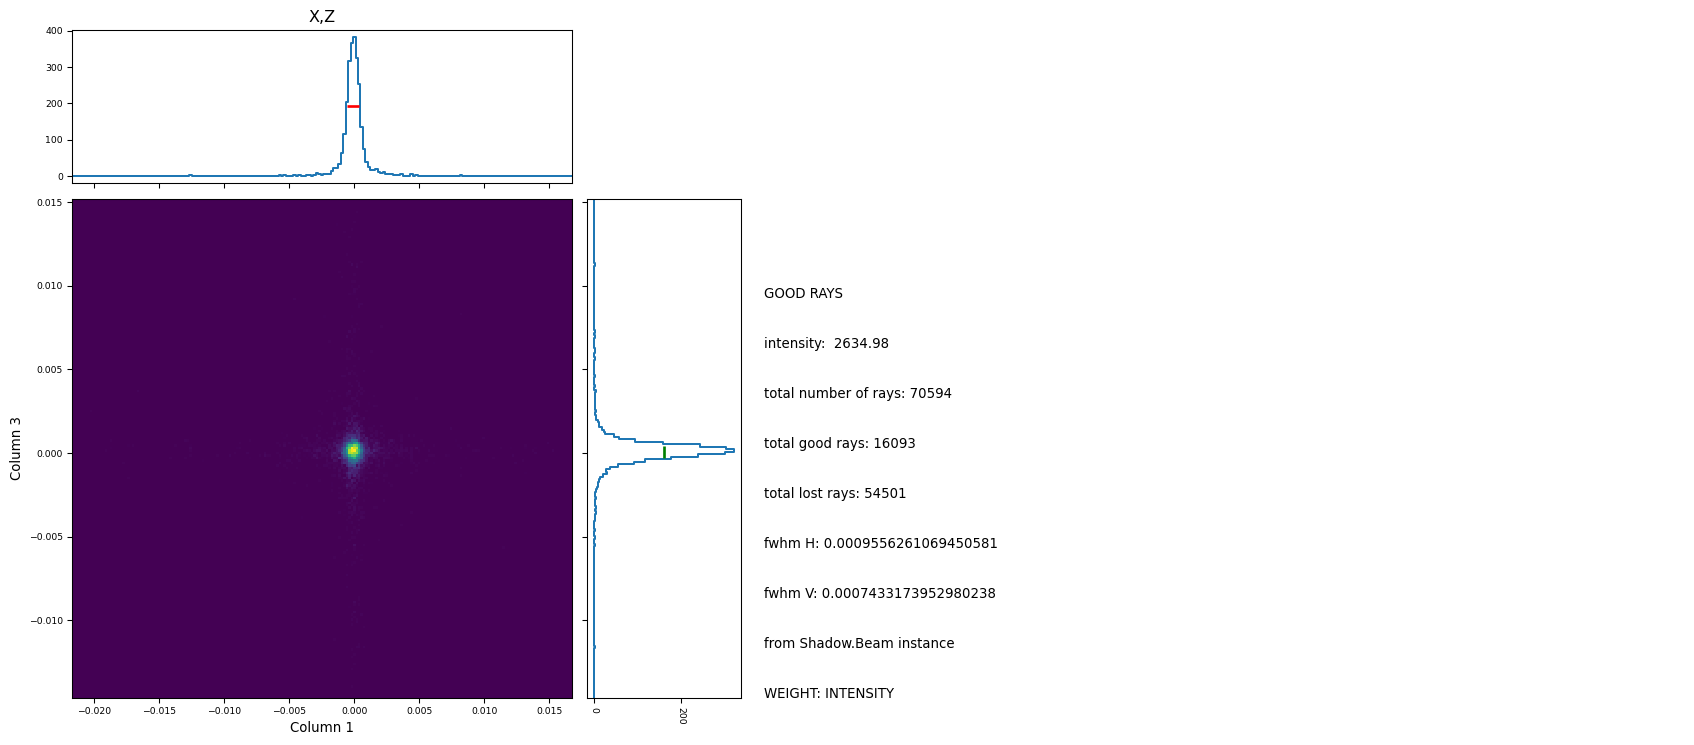

%px: 100%|██████████| 1/1 [00:02<00:00,  2.48s/tasks]


In [34]:
%%px --targets 0 
# this is equivalent to using if rank == 0
centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system=focusing_system, 
                                                                random_seed=DEFAULT_RANDOM_SEED)
print(centroid)

_ = plot_shadow_beam_spatial_distribution(out_beam)

In [56]:
%%px --targets 0
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))

In [59]:
root.push({'initial_absolute_positions':initial_absolute_positions})

NameError: name 'initial_absolute_positions' is not defined

In [66]:
root.__dict__

{'_trait_values': {'client': <ipyparallel.client.client.Client at 0x14afc77d5a90>,
  '_socket': <zmq.eventloop.zmqstream.ZMQStream at 0x14afc77cd450>,
  'results': defaultdict(dict, {}),
  'block': False,
  'targets': 0,
  '_flag_names': ['targets', 'block', 'track']},
 '_trait_notifiers': {},
 '_trait_validators': {},
 '_cross_validation_lock': False,
 'executor': <ipyparallel.client.view.ViewExecutor at 0x14ae90e59390>}

In [64]:
rc[4]

IndexError: No such engine: 4

In [54]:
dv['initial_absolute_positions']

CompositeError: one or more exceptions raised in: _pull
[1:apply]NameError: name 'initial_absolute_positions' is not defined
[2:apply]NameError: name 'initial_absolute_positions' is not defined
[3:apply]NameError: name 'initial_absolute_positions' is not defined

In [52]:
initial_absolute_positions

<AsyncResult(_push): finished>

In [48]:
dv[0]

TypeError: names must be strs, not 0

In [44]:
initial_absolute_positions = dv.pull('initial_absolute_positions', targets = 0)

In [45]:
dv['initial_absolute_positons'] = initial_absolute_positions

array([0.])

In [46]:
??dv.push

Signature: dv.push(ns, targets=None, block=None, track=None)
Source:   
    def push(self, ns, targets=None, block=None, track=None):
        """update remote namespace with dict `ns`

        Parameters
        ----------
        ns : dict
            dict of keys with which to update engine namespace(s)
        block : bool [default : self.block]
            whether to wait to be notified of engine receipt

        """

        block = block if block is not None else self.block
        track = track if track is not None else self.track
        targets = targets if targets is not None else self.targets
        # applier = self.apply_sync if block else self.apply_async
        if not isinstance(ns, dict):
            raise TypeError("Must be a dict, not %s" % type(ns))
        return self._really_apply(
            util._push, kwargs=ns, block=block, track=track, targets=targets
        )
File:      ~/.conda/envs/oasys_env/lib/python3.7/site-packages/ipyparallel/client/view.py
Type:   

In [42]:
dv.block = True

In [25]:
%%px --targets 0
if rank == 0:
    initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
    print(initial_absolute_positions)
else:
    initial_absolute_positions = None

initial_absolute_positions = MPI.COMM_WORLD.bcast(initial_absolute_positions, root=0)

[stdout:0] [0.]


In [27]:
%%px 
initial_centroids = []
initial_out_beams = []
absolute_movements = []

start_guesses = []
overall_successes = []
final_centroids = []
final_out_beams = []
opt_results_all = []

min_trans = -0.14
max_trans = 0.14

for outer in tqdm(range(1)):
    translations = np.random.uniform(min_trans, max_trans, size=1)
    test_absolute_movements = initial_absolute_positions + translations
    print("Initial motor positions are", test_absolute_movements)
    absolute_movements.append(test_absolute_movements)
    
    focusing_system = movers.move_motors(focusing_system, move_motors, 
                                         test_absolute_movements,
                                         movement='absolute')
    centroid, out_beam, hist, dw = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    
    initial_centroids.append(centroid)
    initial_out_beams.append(out_beam)
    
    opt_trial = opt_common.OptimizationCommon(focusing_system, 
                                          motor_types=move_motors, 
                                          initial_motor_positions=test_absolute_movements, 
                                          random_seed=DEFAULT_RANDOM_SEED)
    
    opt_results, guesses, solution, success = opt_trial.trials(verbose=False, guess_min=min_trans, guess_max=max_trans)
    focusing_system = opt_trial.focusing_system
    opt_results_all.append(opt_results)
    
    start_guesses.append(guesses)
    overall_successes.append(success)
    centroid, out_beam, *_ = opt_common.get_centroid_distance(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
    final_centroids.append(centroid)
    final_out_beams.append(out_beam)
    print(f'Test {outer} success {success}')

[stderr:2]   0%|          | 0/1 [00:00<?, ?it/s]/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_elements/bl/hybrid_control.py:168: RankWarning: Polyfit may be poorly conditioned
  hy_readfiles(input_parameters, calculation_parameters)	#Read shadow output files needed by HYBRID
/home/skandel/.conda/envs/oasys_env/lib/python3.7/site-packages/orangecontrib/shadow/widgets/special_el

[stderr:1] 100%|██████████| 1/1 [00:40<00:00, 40.65s/it]


[stderr:3] 100%|██████████| 1/1 [00:28<00:00, 28.35s/it]


[stderr:0] 100%|██████████| 1/1 [00:31<00:00, 31.29s/it]


[stdout:0] Initial motor positions are [0.09666443]
Initial loss is 0.09641166181973959
initial guess is [-0.11091503]
Test 0 success True


[stdout:2] Initial motor positions are [0.03663923]
Initial loss is 0.036573898383821135
initial guess is [0.1311414]
Initial loss is 0.036573898383821135
initial guess is [0.01119911]
Test 0 success True


[stdout:1] Initial motor positions are [0.00715946]
Initial loss is 0.007222521064733849
initial guess is [-0.12097998]
Test 0 success True


[stdout:3] Initial motor positions are [-0.09857697]
Initial loss is 0.09837007039132002
initial guess is [0.08428886]
Test 0 success True


%px: 100%|██████████| 4/4 [00:51<00:00, 12.96s/tasks]


In [34]:
%px absolute_movements = MPI.COMM_WORLD.gather(absolute_movements)

In [44]:
%%px
sendbuf = None
if rank == 0:
    sendbuf = np.array(absolute_movements)
    
recvbuf = np.empty(1)
MPI.COMM_WORLD.Scatter(sendbuf, recvbuf, root=0)

In [52]:
%%px
absolute_movements = np.empty(4)
MPI.COMM_WORLD.Gather(recvbuf, absolute_movements, root=0)

In [53]:
%%px
print(recvbuf, absolute_movements)

[stdout:0] [0.09666443] [ 0.09666443  0.00715946  0.03663923 -0.09857697]


[stdout:2] [0.03663923] [45.12669836 44.79343723 48.10218485 44.21614995]


[stdout:3] [-0.09857697] [45.12582566 45.31459505 47.58268951 44.21613378]


[stdout:1] [0.00715946] [44.8318965  44.43958139 48.45648057 44.21621856]


In [41]:
%%px
print(absolute_movements)

[stdout:2] None


[stdout:1] None


[stdout:3] None


[stdout:0] [[array([0.09666443])], [array([0.00715946])], [array([0.03663923])], [array([-0.09857697])]]


In [30]:
%%px
movements_mpi = MPI.COMM_WORLD.gather(absolute_movements)
opt_results_all_mpi = MPI.COMM_WORLD.gather(opt_results_all)

In [31]:
%%px --targets 0
opt_results_all_mpi

Out[0:23]: 
[[[ final_simplex: (array([[-0.09668238],
          [-0.09661739]]), array([0.00013461, 0.00017186]))
              fun: 0.00013460594840493964
          message: 'Optimization terminated successfully.'
             nfev: 14
              nit: 7
           status: 0
          success: True
                x: array([-0.09668238])]],
 [[ final_simplex: (array([[-0.00718909],
          [-0.00713593]]), array([0.00013026, 0.00015626]))
              fun: 0.00013026281909920027
          message: 'Optimization terminated successfully.'
             nfev: 20
              nit: 10
           status: 0
          success: True
                x: array([-0.00718909])]],
 [[ final_simplex: (array([[0.1311414],
          [0.1311414]]), array([0.13337013, 0.13337013]))
              fun: 0.1333701263469785
          message: 'Optimization terminated successfully.'
             nfev: 5
              nit: 2
           status: 0
          success: True
                x: array([0.1311414])

In [54]:
!ls

gaussian_process_vkb_4_hkb_4.ipynb  scrap.ipynb
hkb_3_opt.ipynb			    test_all_motors_clean.ipynb
hkb_4_gp_domain_kernel_tests.ipynb  test_all_motors.ipynb
hkb_4_opt.ipynb			    untitled.py
hkb_4_vkb_4.ipynb		    vkb_3_opt.ipynb
hkb_q_opt.ipynb			    vkb_4_opt.ipynb
parallel_test_loss_function.ipynb   vkb_q_hkb_q.ipynb
readme.md			    vkb_q.ipynb
run_focusing_system.ipynb
